# How to train and tune a random forest

In [2]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import numpy as np
from numpy.random import choice, normal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve
from sklearn.externals import joblib
warnings.filterwarnings('ignore')

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
plt.style.use('fivethirtyeight')
np.random.seed(seed=42)

## Get Data

In [4]:
with pd.HDFStore('data_v1.h5') as store:
    data =store['data']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 171162 entries, (A, 2011-03-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 61 columns):
returns                  171162 non-null float64
t-1                      171162 non-null float64
t-2                      171162 non-null float64
t-3                      171162 non-null float64
t-4                      171162 non-null float64
t-5                      171162 non-null float64
t-6                      171162 non-null float64
t-7                      171162 non-null float64
t-8                      171162 non-null float64
t-9                      171162 non-null float64
t-10                     171162 non-null float64
t-11                     171162 non-null float64
t-12                     171162 non-null float64
year_2011                171162 non-null uint8
year_2012                171162 non-null uint8
year_2013                171162 non-null uint8
year_2014                171162 non-null uint8
year_2015           

### Stock Prices

In [5]:
y = data.returns
y_binary = (y > 0).astype(int)
X = data.drop('returns', axis=1)

## Explore Data

In [6]:
y.describe(percentiles=np.arange(.1, .91, .1))

count    171162.000000
mean          0.009827
std           0.068340
min          -0.152427
10%          -0.080626
20%          -0.048064
30%          -0.025061
40%          -0.006481
50%           0.009259
60%           0.025641
70%           0.043847
80%           0.066246
90%           0.100111
max           0.185083
Name: returns, dtype: float64

## Custom KFold

In [7]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Benchmarks

### Regression

In [8]:
def regression_benchmark():
    rmse = []
    for train_idx, test_idx in cv.split(X):
        mean = y.iloc[train_idx].mean()
        data = y.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        rmse.append(np.sqrt(mean_squared_error(data.y_test, data.y_pred))) 
    return np.mean(rmse)

### Classification

In [9]:
def classification_benchmark():
    auc = []
    for train_idx, test_idx in cv.split(X):
        mean = y_binary.iloc[train_idx].mean()
        data = y_binary.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        auc.append(roc_auc_score(data.y_test, data.y_pred))
    return np.mean(auc)

## Bagged Decision Trees

To apply bagging to decision trees, we create bootstrap samples from our training data by repeatedly sampling with replacement, then train one decision tree on each of these samples, and create an ensemble prediction by averaging over the predictions of the different trees.

Bagged decision trees are usually grown large, that is, have many levels and leaf nodes and are not pruned so that each tree has low bias but high variance. The effect of averaging their predictions then aims to reduce their variance. Bagging has been shown to substantially improve predictive performance by constructing ensembles that combine hundreds or even thousands of trees trained on bootstrap samples.

To illustrate the effect of bagging on the variance of a regression tree, we can use the `BaggingRegressor` meta-estimator provided by `sklearn`. It trains a user-defined base estimator based on parameters that specify the sampling strategy:

- `max_samples` and `max_features` control the size of the subsets drawn from the rows and the columns, respectively
- `bootstrap` and `bootstrap_features` determine whether each of these samples is drawn with or without replacement

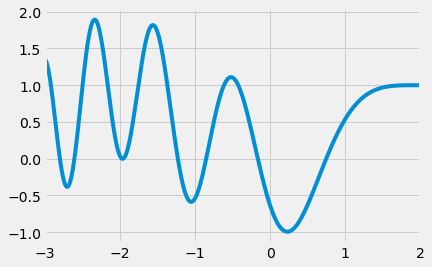

In [10]:
def f(x):
    return np.exp(-(x+2) ** 2) + np.cos((x-2)**2)

x = np.linspace(-3, 2, 1000)
y = pd.Series(f(x), index=x)
y.plot();

The following example uses the preceding exponential function `f(x)` to generate training samples for a single DecisionTreeRegressor and a BaggingRegressor ensemble that consists of ten trees, each grown ten levels deep. Both models are trained on the random samples and predict outcomes for the actual function with added noise.

Since we know the true function, we can decompose the mean-squared error into bias, variance, and noise, and compare the relative size of these components for both models according to the following breakdown:

For 100 repeated random training and test samples of 250 and 500 observations each, we find that the variance of the predictions of the individual decision tree is almost twice as high as that for the small ensemble of 10 bagged trees based on bootstrapped samples:

In [11]:
test_size = 500
train_size = 250
reps = 100

noise = .5  # noise relative to std(y)
noise = y.std() * noise

X_test = choice(x, size=test_size, replace=False)

max_depth = 10
n_estimators=10

tree = DecisionTreeRegressor(max_depth=max_depth)
bagged_tree = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators)
learners = {'Decision Tree': tree, 'Bagging Regressor': bagged_tree}

predictions = {k: pd.DataFrame() for k, v in learners.items()}
for i in range(reps):
    X_train = choice(x, train_size)
    y_train = f(X_train) + normal(scale=noise, size=train_size)
    for label, learner in learners.items():
        learner.fit(X=X_train.reshape(-1, 1), y=y_train)
        preds = pd.DataFrame({i: learner.predict(X_test.reshape(-1, 1))}, index=X_test)
        predictions[label] = pd.concat([predictions[label], preds], axis=1)

In [12]:
# y only observed with noise
y_true = pd.Series(f(X_test), index=X_test)
y_test = pd.DataFrame(y_true.values.reshape(-1,1) + normal(scale=noise, size=(test_size, reps)), index=X_test)

In [13]:
result = pd.DataFrame()
for label, preds in predictions.items():
    result[(label, 'error')] = preds.sub(y_test, axis=0).pow(2).mean(1)    # mean squared error
    result[(label, 'bias')] = y_true.sub(preds.mean(axis=1), axis=0).pow(2)             # bias
    result[(label, 'variance')] = preds.var(axis=1)
    result[(label, 'noise', )] = y_test.var(axis=1)
result.columns = pd.MultiIndex.from_tuples(result.columns)

In [14]:
df = result.mean().sort_index().loc['Decision Tree']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.29%'

In [15]:
df = result.mean().sort_index().loc['Bagging Regressor']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.22%'

### Visualize Bias-Variance Breakdown

For each model, the following plot shows the mean prediction and a band of two standard deviations around the mean for both models in the upper panel, and the bias-variance-noise breakdown based on the values for the true function in the bottom panel:

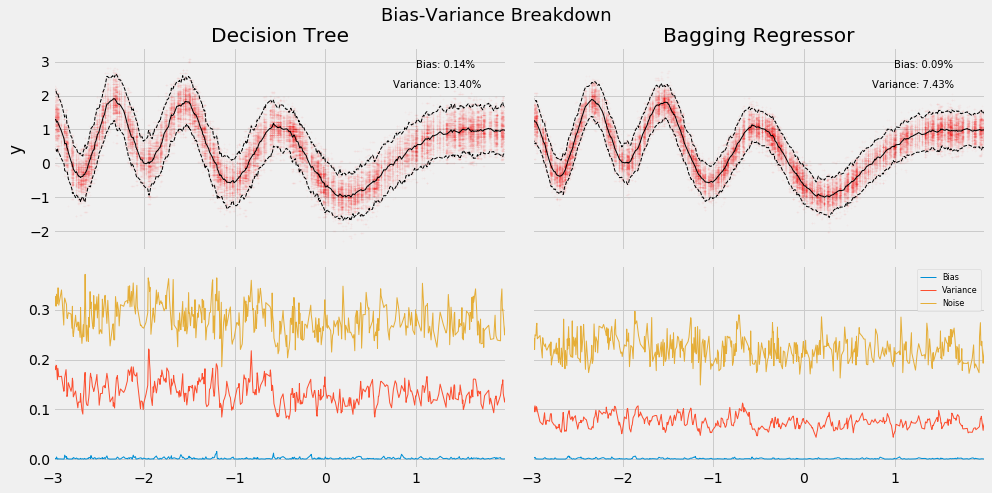

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 7), sharex=True, sharey='row')
axes = axes.flatten()
idx = pd.IndexSlice

for i, (model, data) in enumerate(predictions.items()):
    mean, std = data.mean(1), data.std(1).mul(2)
    (pd.DataFrame([mean.sub(std), mean, mean.add(std)]).T
     .sort_index()
     .plot(style=['k--', 'k-', 'k--'], ax=axes[i], lw=1, legend=False))
    (data.stack().reset_index()
     .rename(columns={'level_0': 'x', 0: 'y'})
     .plot.scatter(x='x', y='y', ax=axes[i], alpha=.02, s=2, color='r', title=model))
    r = result[model]
    m = r.mean()
    kwargs = {'transform': axes[i].transAxes, 'fontsize':10}
    axes[i].text(x=.8, y=.9, s=f'Bias: {m.bias:.2%}', **kwargs)
    axes[i].text(x=.75, y=.8, s=f'Variance: {m.variance:.2%}', **kwargs)
    
    (r.drop('error', axis=1).sort_index()
     .rename(columns=str.capitalize)
     .plot(ax=axes[i+2], lw=1, legend=False, stacked=True))

axes[-1].legend(fontsize=8)
fig.suptitle('Bias-Variance Breakdown', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('bias_variance_bagging', dpi=600);

## Random Forests

### Classifier

### Cross-Validation with default settings

In [17]:
rf_clf = RandomForestClassifier(n_estimators=200,             # default changed from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

In [18]:
cv = OneStepTimeSeriesSplit(n_splits=12, test_period_length=1, shuffle=True)

In [19]:
cv_score = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y_binary,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  3.8min remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.8min finished


In [20]:
np.mean(cv_score)

0.521467856810403

### Parameter Tuning

The key configuration parameters include the various hyperparameters for the individual decision trees introduced in the notebook [decision_trees](01_decision_trees.ipynb). 

The following tables lists additional options for the two `RandomForest` classes:

| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the R2 on unseen data                                                                   |
| warm_start   | False   | Reuse result of previous call to continue training and add more trees to the ensemble, otherwise, train a whole new forest |

- The `bootstrap` parameter activates in the preceding bagging algorithm outline, which in turn enables the computation of the out-of-bag score (oob_score) that estimates the generalization accuracy using samples not included in the bootstrap sample used to train a given tree (see next section for detail). 
- The `n_estimators` parameter defines the number of trees to be grown as part of the forest. Larger forests perform better, but also take more time to build. It is important to monitor the cross-validation error as a function of the number of base learners to identify when the marginal reduction of the prediction error declines and the cost of additional training begins to outweigh the benefits.
- The `max_features` parameter controls the size of the randomly selected feature subsets available when learning a new decision rule and split a node. A lower value reduces the correlation of the trees and, thus, the ensemble's variance, but may also increase the bias. Good starting values are `n_features` (the number of training features) for regression problems and `sqrt(n_features)` for classification problems, but will depend on the relationships among features and should be optimized using cross-validation.

Random forests are designed to contain deep fully-grown trees, which can be created using `max_depth=None` and `min_samples_split=2`. However, these values are not necessarily optimal, especially for high-dimensional data with many samples and, consequently, potentially very deep trees that can become very computationally-, and memory-, intensive.

The `RandomForest` class provided by sklearn support parallel training and prediction by setting the n_jobs parameter to the k number of jobs to run on different cores. The -1 value uses all available cores. The overhead of interprocess communication may limit the speedup from being linear so that k jobs may take more than 1/k the time of a single job. Nonetheless, the speedup is often quite significant for large forests or deep individual trees that may take a meaningful amount of time to train when the data is large, and split evaluation becomes costly.

As always, the best parameter configuration should be identified using cross-validation. The following steps illustrate the process:

#### Define Parameter Grid

In [21]:
param_grid = {'n_estimators': [200, 400],
              'max_depth': [10, 15, 20],
              'min_samples_leaf': [50, 100],
              }

#### Instantiate GridSearchCV

We will use 10-fold custom cross-validation and populate the parameter grid with values for the key configuration settings:

In [22]:
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

#### Fit

In [ ]:
gridsearch_clf.fit(X=X, y=y_binary)

#### Persist Result

In [ ]:
joblib.dump(gridsearch_clf, 'gridsearch_clf.joblib') 

In [24]:
gridsearch_clf = joblib.load('gridsearch_clf.joblib') 

In [25]:
gridsearch_clf.best_params_

{'max_depth': 20, 'min_samples_leaf': 50, 'n_estimators': 400}

In [26]:
gridsearch_clf.best_score_

0.5269293386898619

### Feature Importance

A random forest ensemble may contain hundreds of individual trees, but it is still possible to obtain an overall summary measure of feature importance from bagged models.

For a given feature, the importance score is the total reduction in the objective function's value, which results from splits based on this feature, averaged over all trees. Since the objective function takes into account how many features are affected by a split, this measure is implicitly a weighted average so that features used near the top of a tree will get higher scores due to the larger number of observations contained in the much smaller number of available nodes. By averaging over many trees grown in a randomized fashion, the feature importance estimate loses some variance and becomes more accurate.

The computation differs for classification and regression trees based on the different objectives used to learn the decision rules and is measured in terms of the mean square error for regression trees and the Gini index or entropy for classification trees.

`sklearn` further normalizes the feature-importance measure so that it sums up to 1. Feature importance thus computed is also used for feature selection as an alternative to the mutual information measures we saw in Chapter 6, The Machine Learning Process (see SelectFromModel in the sklearn.feature_selection module).
In our example, the importance values for the top-20 features are as shown here:

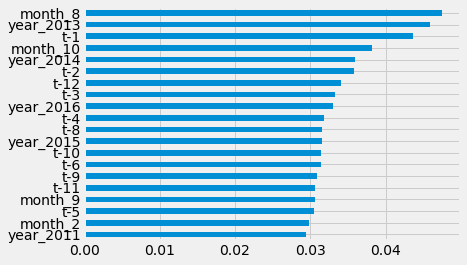

In [27]:
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh());

### Regression

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=10, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [ ]:
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
gridsearch_reg.fit(X=X, y=y)

In [ ]:
joblib.dump(gridsearch_reg, 'rf_reg_gridsearch.joblib') 

In [28]:
gridsearch_reg = joblib.load('rf_reg_gridsearch.joblib') 

In [29]:
gridsearch_reg.best_params_

{'max_depth': 10, 'min_samples_leaf': 100, 'n_estimators': 200}

In [30]:
f'{np.sqrt(-gridsearch_reg.best_score_):.2%}'

'7.16%'

In [ ]:
f'{regression_benchmark():.2%}'